In [497]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import svm, feature_selection, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import graphingFunctions as gf
import modelingFunctions as mf
importlib.reload(gf)
importlib.reload(mf)

<module 'modelingFunctions' from 'c:\\Users\\zacha\\Documents\\co3093-cw\\modelingFunctions.py'>

In [498]:
def markOutliers(df,columns):

    t = np.zeros(df.shape[0])
    z = np.zeros(df.shape[0])
    for column in columns:
        mean=np.mean(df[column])
        sd=np.std(df[column])
        threshold=2
        test=[]

        for i, x in enumerate(df[column]):
            if column=="SALE_PRICE":
                if x<75000:
                    t[i]=1
            z[i]=(x-mean)/sd
            if z[i]>=threshold:
                test.append((x,z[i]))
                t[i]=1
    df['outlier']=t
    
    return df

In [499]:
def categorizeNeighborhood(df):
    group = df.groupby("NEIGHBORHOOD")["SALE_PRICE"].mean().reset_index()
    group = group.rename(columns={"SALE_PRICE": "AVG_SALE_PRICE"})
    
    df = pd.merge(df, group, on="NEIGHBORHOOD", how="left")
    
    bins = [-np.inf, group["AVG_SALE_PRICE"].quantile(1/3), group["AVG_SALE_PRICE"].quantile(2/3), np.inf]
    n_cat = pd.cut(df["AVG_SALE_PRICE"], bins=bins, labels=[1,2,3])
    df = df.join(n_cat, rsuffix='_CATEGORY')
    return df

In [506]:
def markOutliersPerNieghborhood(df):
    groupedDF = df.groupby("NEIGHBORHOOD")
    t = np.zeros(df.shape[0])
    for n, g in groupedDF:
        q1 = g['lnprice'].quantile(0.25)
        q3 = g['lnprice'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        for i, r in g.iterrows():
            if not pd.isnull(r['lnprice']) and (r['lnprice'] <= lower_bound or r['lnprice'] >= upper_bound and r['lnprice']!=0):
                t[i] = 1
    q1 = df['lnprice'].quantile(0.25)
    q3 = df['lnprice'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    for i, r in df.iterrows():
        if not pd.isnull(r['lnprice']) and (r['lnprice'] <= lower_bound or r['lnprice'] >= upper_bound and r['lnprice']!=0):
            t[i] = 1
            
    for n, g in groupedDF:
        q1 = g['SALE_PRICE'].quantile(0.25)
        q3 = g['SALE_PRICE'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        for i, r in g.iterrows():
            if not pd.isnull(r['SALE_PRICE']) and (r['SALE_PRICE'] <= lower_bound or r['SALE_PRICE'] >= upper_bound and r['SALE_PRICE']!=0):
                t[i] = 1
    q1 = df['SALE_PRICE'].quantile(0.25)
    q3 = df['SALE_PRICE'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    for i, r in df.iterrows():
        if not pd.isnull(r['SALE_PRICE']) and (r['SALE_PRICE'] <= lower_bound or r['SALE_PRICE'] >= upper_bound and r['SALE_PRICE']!=0):
            t[i] = 1
    df['outlier']=t
    return df

def markOutliersPerNieghborhoodSP(df):
    groupedDF = df.groupby("NEIGHBORHOOD")
    t = np.zeros(df.shape[0])
    for n, g in groupedDF:
        q1 = g['SALE_PRICE'].quantile(0.25)
        q3 = g['SALE_PRICE'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        for i, r in g.iterrows():
            if not pd.isnull(r['SALE_PRICE']) and (r['SALE_PRICE'] <= lower_bound or r['SALE_PRICE'] >= upper_bound and r['SALE_PRICE']!=0):
                t[i] = 1
    q1 = df['SALE_PRICE'].quantile(0.25)
    q3 = df['SALE_PRICE'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    for i, r in df.iterrows():
        if not pd.isnull(r['SALE_PRICE']) and (r['SALE_PRICE'] <= lower_bound or r['SALE_PRICE'] >= upper_bound and r['SALE_PRICE']!=0):
            t[i] = 1
    df['outlier']=t
    return df

def checkUnits(df):
    t = np.zeros(df.shape[0])
    for i, r in df.iterrows():
        if r["RESIDENTIAL_UNITS"]==0 and r["COMMERCIAL_UNITS"]==0 and pd.isnull(r["TOTAL_UNITS"]):
            t[i]=1
        if r["LAND_SQUARE_FEET"]==0 and r["GROSS_SQUARE_FEET"]==0 and r["SALE_PRICE"]==0:
            t[i]=1
    df['no_units']=t
    return df   

def fillSquareFeet(df, column):
    dfComplete=df.copy()
    dfComplete[column]=dfComplete[column].replace(0,np.NaN)
    mean=dfComplete.groupby('NEIGHBORHOOD')[column].mean()
    dfComplete[column].fillna(dfComplete["NEIGHBORHOOD"].map(mean), inplace=True)
    
    return dfComplete

def fillYearBuilt(df):
    dfComplete=df.copy()
    dfComplete["YEAR_BUILT"]=dfComplete["YEAR_BUILT"].replace(0,np.NaN)
    median=dfComplete.groupby(['BLOCK', 'NEIGHBORHOOD'])['YEAR_BUILT'].median()
    median_rounded = median.round().astype('Int64')
    dfComplete["YEAR_BUILT"].fillna(dfComplete.groupby(['BLOCK', 'NEIGHBORHOOD'])["YEAR_BUILT"].transform(lambda x: x.fillna(median_rounded[x.name])), inplace=True)
    
    return dfComplete

def fillBuildingCategory(df):
    dfComplete=df.copy()
    dfComplete['BUILDING_CLASS_CATEGORY'].fillna(dfComplete.groupby(["BUILDING_CLASS_AT_PRESENT", "BUILDING_CLASS_AT_TIME_OF_SALE"])['BUILDING_CLASS_CATEGORY'].apply(lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan).astype('object'), inplace=True)
    #dfComplete.groupby(["BUILDING_CLASS_AT_PRESENT", "BUILDING_CLASS_AT_TIME_OF_SALE"])['BUILDING_CLASS_CATEGORY'].apply(lambda x: print(x.mode()[0] if len(x.mode()) > 0 else np.nan))
    return dfComplete


In [507]:
def fillBasedOnCoef(dforigin, target, col1, col2):
    updated = False
    df=dforigin.copy()
    dfComplete=df.copy()
    dfComplete[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET", "SALE_PRICE"]]=dfComplete[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET", "SALE_PRICE"]].replace(0,np.NaN)
    dfComplete.dropna(inplace=True)
    x=dfComplete[[col1, col2]]
    y=dfComplete[target]

    model = linear_model.LinearRegression().fit(x, y)

    first_coef = model.coef_[0]
    sec_coef = model.coef_[1]
    df[target]=df[target].replace(np.NaN, 0)
    df[target] = np.where((df[target] == 0) & (df[col1] > 0) & (df[col2] > 0),
        (df[col1] * first_coef) + (df[col2] * sec_coef),df[target])
    if df[target].eq(dforigin[target]).all():
        updated = True
    df[target]=df[target].replace(0, np.NaN)
    return df, updated

In [ ]:

def regressionFillSL(df):
    import statsmodels.formula.api as smf
    dfComplete=df.copy()
    dfComplete[['SALE_PRICE', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']]=dfComplete[['SALE_PRICE', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']].replace(0,np.NaN)
    dfComplete.dropna(inplace=True)
    dfComplete.reset_index(drop=True, inplace=True)
 
    model = smf.ols(formula='SALE_PRICE~LAND_SQUARE_FEET', data=dfComplete).fit()
    print(model.params)
    print('R squared is: ', model.rsquared)
    print(model.summary())

def regressionFillSG(df):
    import statsmodels.formula.api as smf
    dfComplete=df.copy()
    dfComplete[['SALE_PRICE', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']]=dfComplete[['SALE_PRICE', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']].replace(0,np.NaN)
    dfComplete.dropna(inplace=True)
    dfComplete.reset_index(drop=True, inplace=True)
 
    model = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET', data=dfComplete).fit()
    print(model.params)
    print('R squared is: ', model.rsquared)
    print(model.summary())


In [501]:
def step2_clean():
    df = pd.read_csv("Manhattan12.csv")

    # Print shape
    print(df.shape)

    # Rename incorrect column names
    df.rename(columns={"APART\r\nMENT\r\nNUMBER":"APARTMENT NUMBER", "SALE\r\nPRICE":"SALE PRICE"}, inplace = True)
    numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE']
    categorical=['BOROUGH','NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT','EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'
    ]
    df.columns=df.columns.str.replace(' ', '_')

    df[numerical]=df[numerical].replace('\$','', regex=True)
    df[numerical]=df[numerical].replace(',','', regex=True)


    df['SALE_DATE']=pd.to_datetime(df['SALE_DATE'], dayfirst=True)
    df[categorical]=df[categorical].replace(' ', '', regex=True)
    df[categorical]=df[categorical].replace('', np.NaN)

    df[numerical]=df[numerical].apply(pd.to_numeric)

    #df[["LAND_SQUARE_FEET","GROSS_SQUARE_FEET", "SALE_PRICE"]]=df[["LAND_SQUARE_FEET","GROSS_SQUARE_FEET", "SALE_PRICE"]].replace(0, np.NaN)
    #print(df.isnull().sum())
    df["SALE_PRICE"]=df["SALE_PRICE"].replace(0, np.NaN)
    
    df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT_NUMBER'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df=fillYearBuilt(df)
      
    
    df['lnprice']=np.log(df["SALE_PRICE"])
    df=markOutliersPerNieghborhood(df)
    df=df[df.outlier==0]
    df=df.drop('outlier', axis=1)
    df.reset_index(drop=True, inplace=True)
    df.drop(columns=['lnprice'],inplace=True)
    print(df.columns)
   
    df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']]=df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']].replace(0,np.NaN)
    df=mf.itImputations(df,['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE'])
    
    df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']]=df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']].replace(0,np.NaN)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['lnprice']=np.log(df["SALE_PRICE"])
    df=markOutliersPerNieghborhood(df)
    df=df[df.outlier==0]
    df=df.drop('outlier', axis=1)
    df.reset_index(drop=True, inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(df.shape, df.isnull().sum())
    df=categorizeNeighborhood(df)
    df.to_csv("squareFill.csv")
    print(df.shape)

    return df

In [489]:
def normalize(df, num_cols):
    df_norm = df.copy()
    for col in num_cols:
        df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())
    return df_norm

In [508]:
df = step2_clean()
df.reset_index(drop=True,inplace=True)
numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE','lnprice']
categorical=['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']

print(df.shape)
dfnorm=normalize(df, numerical)
#df.drop(columns=['SALE_PRICE',], inplace=True)
# dfnorm.drop(columns=['SALE_PRICE',], inplace=True)
# numerical.remove("SALE_PRICE")


(27395, 21)
Index(['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT',
       'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')
RELOADED


c:\Python311\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(16878, 19) NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
lnprice                           0
dtype: int64
(16878, 21)
(16878, 21)


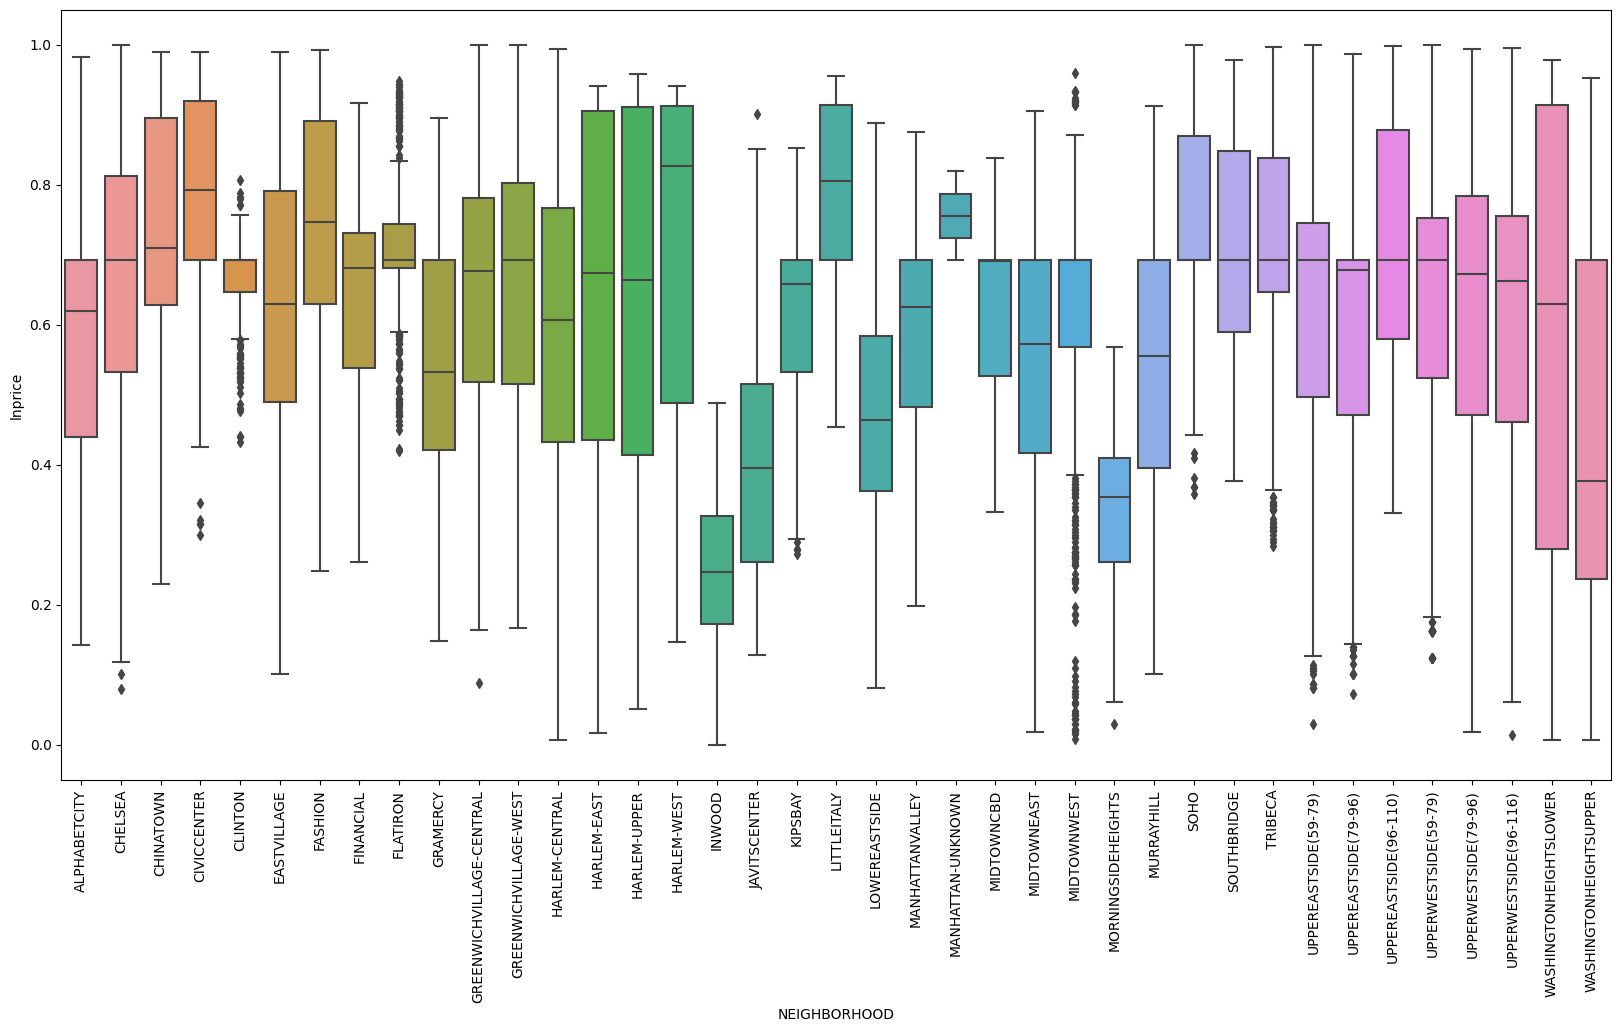

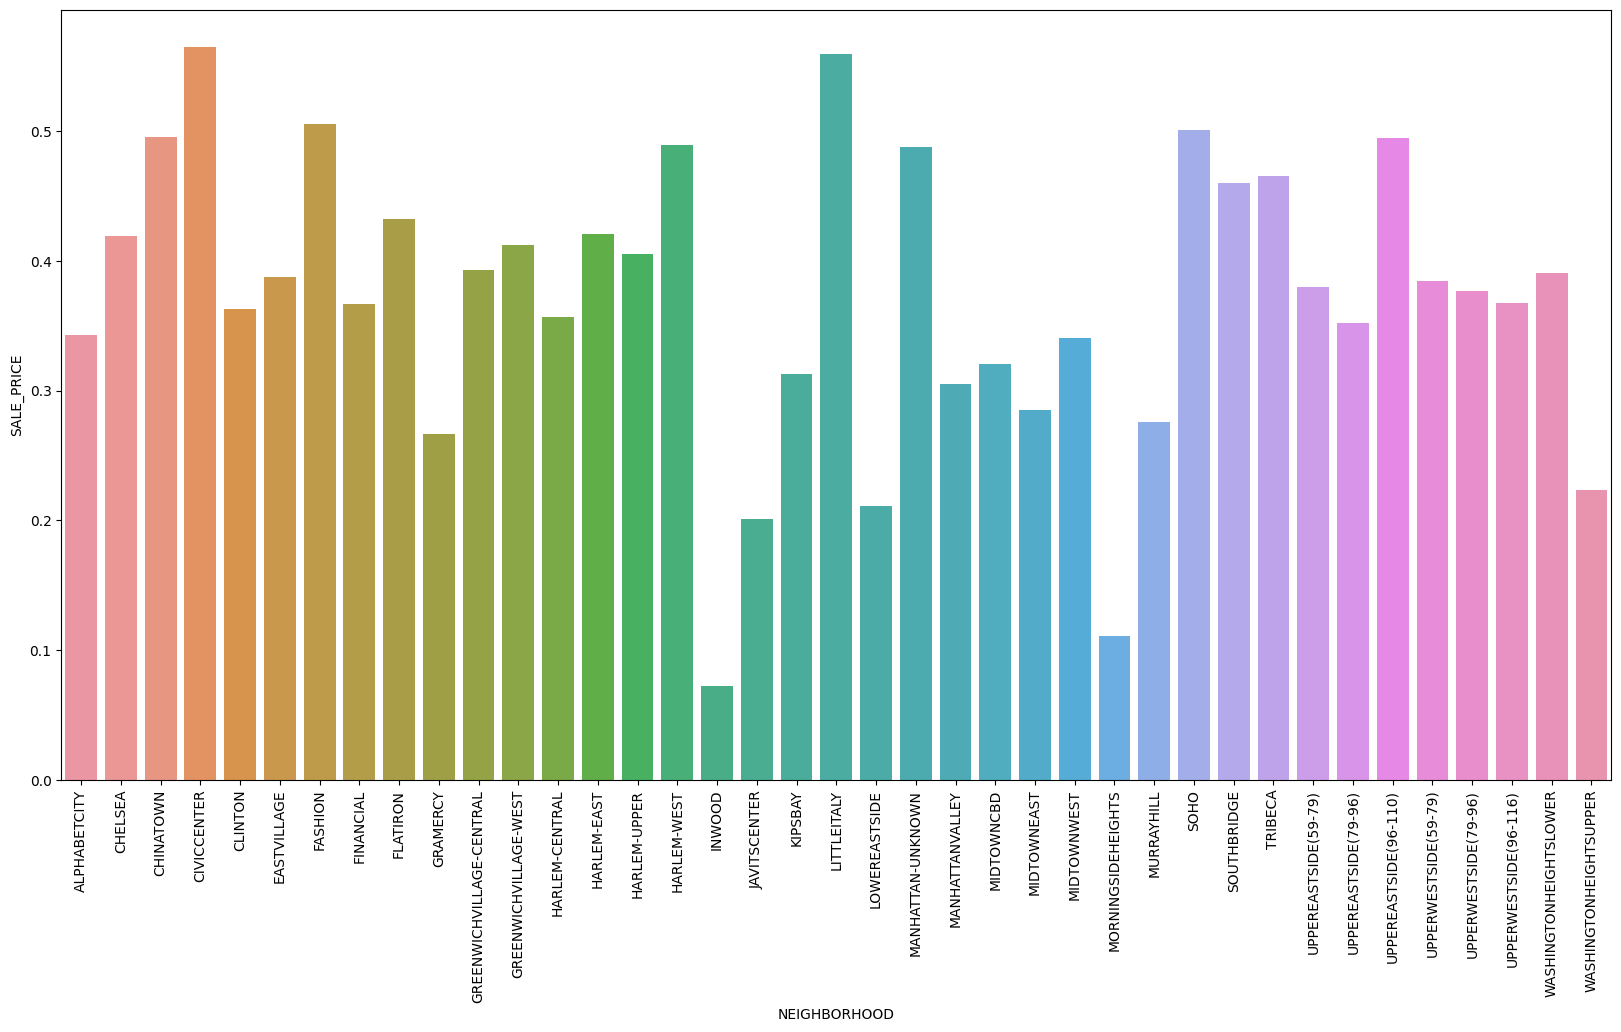

In [510]:
gf.boxPlot(dfnorm, 'lnprice', 'NEIGHBORHOOD')
gf.averagePrice(dfnorm, 'SALE_PRICE', 'NEIGHBORHOOD')

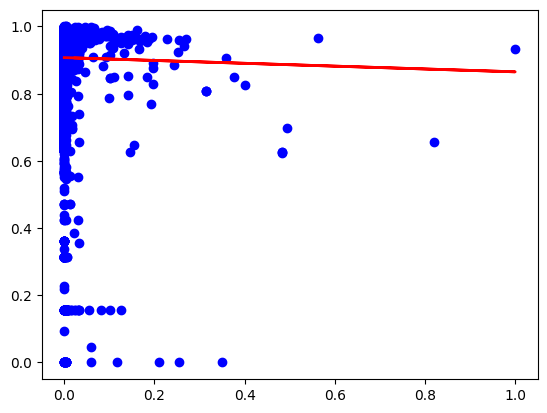


 Intercept            0.907352
RESIDENTIAL_UNITS   -0.042311
dtype: float64
confidence interval:
                           0         1
Intercept          0.905954  0.908750
RESIDENTIAL_UNITS -0.116658  0.032035 

P values:
 Intercept            0.000000
RESIDENTIAL_UNITS    0.264648
dtype: float64
R-Squared 6.815306237029084e-05


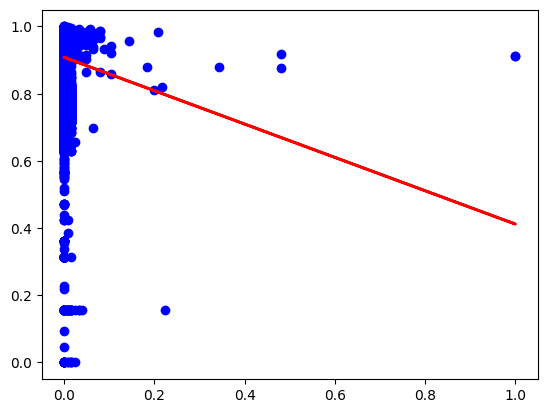


 Intercept           0.907950
COMMERCIAL_UNITS   -0.495896
dtype: float64
confidence interval:
                          0         1
Intercept         0.906570  0.909331
COMMERCIAL_UNITS -0.598319 -0.393473 

P values:
 Intercept           0.000000e+00
COMMERCIAL_UNITS    2.585895e-21
dtype: float64
R-Squared 0.00490874477992298


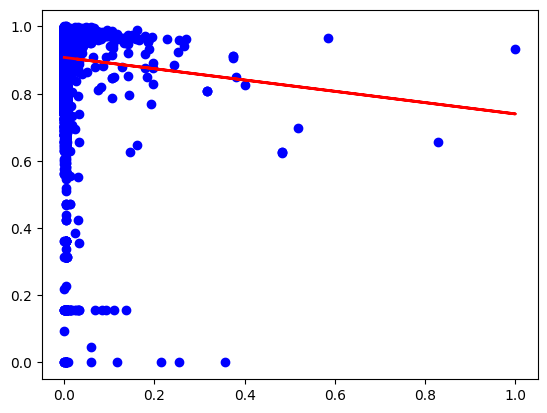


 Intercept      0.907880
TOTAL_UNITS   -0.168058
dtype: float64
confidence interval:
                     0         1
Intercept    0.906477  0.909284
TOTAL_UNITS -0.239013 -0.097103 

P values:
 Intercept      0.000000
TOTAL_UNITS    0.000003
dtype: float64
R-Squared 0.001179144293483092


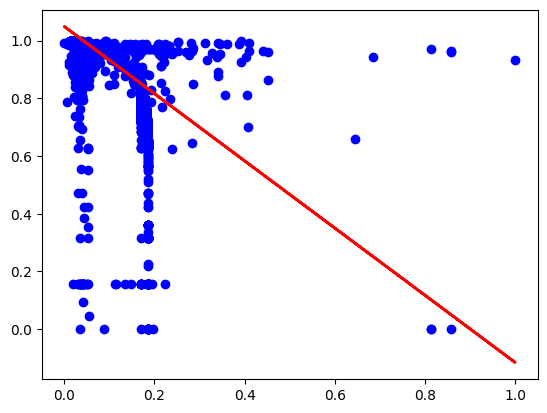


 Intercept           1.048838
LAND_SQUARE_FEET   -1.164279
dtype: float64
confidence interval:
                          0         1
Intercept         1.045308  1.052368
LAND_SQUARE_FEET -1.191652 -1.136905 

P values:
 Intercept           0.0
LAND_SQUARE_FEET    0.0
dtype: float64
R-Squared 0.2757254265216277


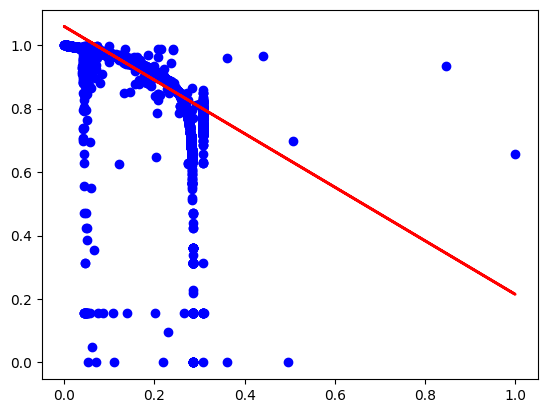


 Intercept            1.058482
GROSS_SQUARE_FEET   -0.843684
dtype: float64
confidence interval:
                           0         1
Intercept          1.055302  1.061662
GROSS_SQUARE_FEET -0.860309 -0.827059 

P values:
 Intercept            0.0
GROSS_SQUARE_FEET    0.0
dtype: float64
R-Squared 0.35148387803030234


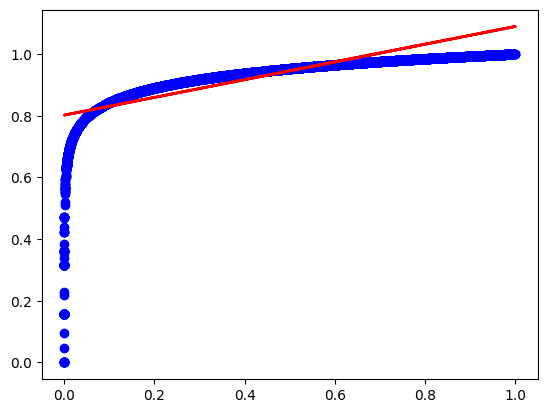


 Intercept     0.801949
SALE_PRICE    0.287384
dtype: float64
confidence interval:
                    0         1
Intercept   0.799917  0.803981
SALE_PRICE  0.282612  0.292156 

P values:
 Intercept     0.0
SALE_PRICE    0.0
dtype: float64
R-Squared 0.4328382947990185


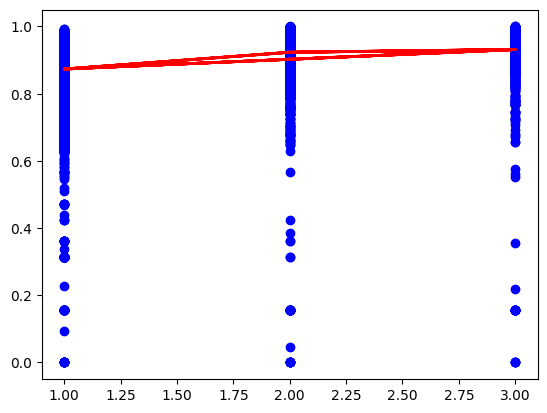


 Intercept                       0.873381
AVG_SALE_PRICE_CATEGORY[T.2]    0.049826
AVG_SALE_PRICE_CATEGORY[T.3]    0.057993
dtype: float64
confidence interval:
                                      0         1
Intercept                     0.871138  0.875624
AVG_SALE_PRICE_CATEGORY[T.2]  0.046868  0.052783
AVG_SALE_PRICE_CATEGORY[T.3]  0.054119  0.061867 

P values:
 Intercept                        0.000000e+00
AVG_SALE_PRICE_CATEGORY[T.2]    2.723905e-232
AVG_SALE_PRICE_CATEGORY[T.3]    5.661876e-185
dtype: float64
R-Squared 0.06948994618648452


In [457]:
#numerical.remove("SALE_PRICE")
numerical.append("AVG_SALE_PRICE_CATEGORY")
for col in numerical:
    if col=="lnprice":
        continue

    gf.regressionFitNumerical(dfnorm, col)



Root Mean Squared Error: 0.06
Cross-validation scores:  [0.96745216 0.71058731 0.96811354 0.97931802 0.95114695]
Mean cross-validation score: 0.92
Y-axis intercept 0.8493
Weight coefficients:
    RESIDENTIAL_UNITS: -3.2194
     COMMERCIAL_UNITS: -1.2568
          TOTAL_UNITS: 3.1887
     LAND_SQUARE_FEET: 5.8371
    GROSS_SQUARE_FEET: -6.0381
R squared for the training data is 0.920
Score against test data: 0.926


<Axes: xlabel='SALE_PRICE', ylabel='Count'>

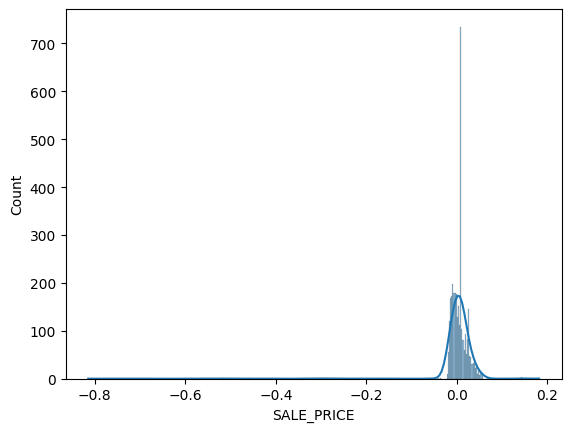

In [511]:

# select_features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
#         'GROSS_SQUARE_FEET', 'NEIGHBORHOOD']
# # Select predictors
# X = dfnorm[select_features]

# # Encode categorical variables using one-hot encoding
# X = pd.get_dummies(X)

# # Target variable
# Y = dfnorm['lnprice']
# trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)
# lm = linear_model.LinearRegression()
# lm.fit(trainX, trainY)
# print("Y-axis intercept {:6.4f}".format(lm.intercept_))
# print("Weight coefficients:")
# for feat, coef in zip(select_features, lm.coef_):
#     print(" {:>20}: {:6.4f}".format(feat, coef))
# # The value of R^2
# print("R squared for the training data is {:4.3f}".format(lm.score(trainX,
# trainY)))
# print("Score against test data: {:4.3f}".format(lm.score(testX, testY)))

select_features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']
# Select predictors
X = dfnorm[select_features]

# Encode categorical variables using one-hot encoding
#X = pd.get_dummies(X)

# Target variable
dfnorm.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
y = dfnorm['SALE_PRICE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: {:.2f}".format(rmse))

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: {:.2f}".format(np.mean(cv_scores)))

print("Y-axis intercept {:6.4f}".format(model.intercept_))
print("Weight coefficients:")
for feat, coef in zip(select_features, model.coef_):
    print(" {:>20}: {:6.4f}".format(feat, coef))
# The value of R^2
print("R squared for the training data is {:4.3f}".format(model.score(X_train,
y_train)))
print("Score against test data: {:4.3f}".format(model.score(X_test, y_test)))

# Plot histogram of residuals
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)

In [512]:
def mse(df, pred, obs):
    n = df.shape[0]
    return sum((df[pred]-df[obs])**2)/n
dfnorm['pred'] = model.predict(X)
print("Mean Squared error: {}".format(mse(dfnorm,'pred', 'SALE_PRICE')))

Mean Squared error: 0.003770223348266884


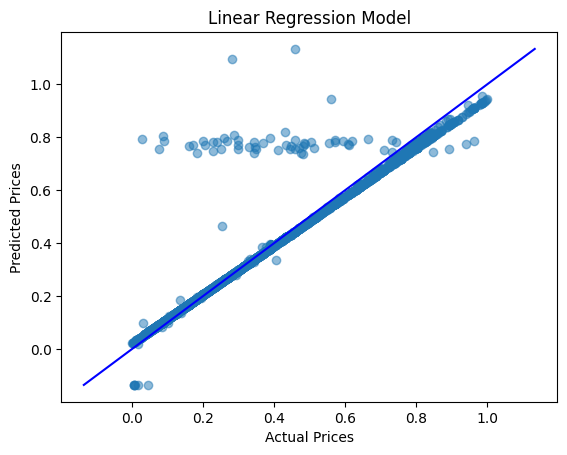

In [513]:
plt.scatter(y_test, y_pred, alpha=0.5)

# Add a regression line to the plot
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')

# Set axis labels and title
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Linear Regression Model')

# Show the plot
plt.show()

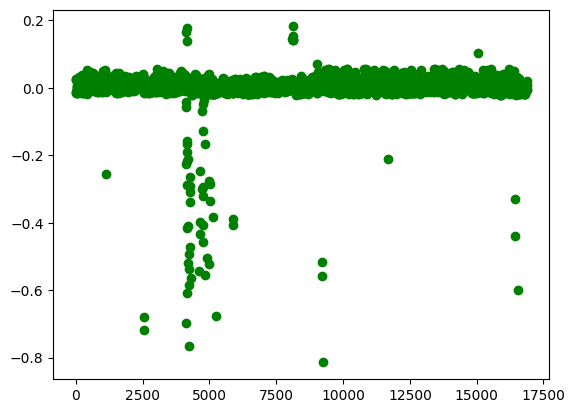

In [514]:
pred=model.predict(X_test)
res=(y_test-pred)
plt.plot(res, 'go')
plt.show()

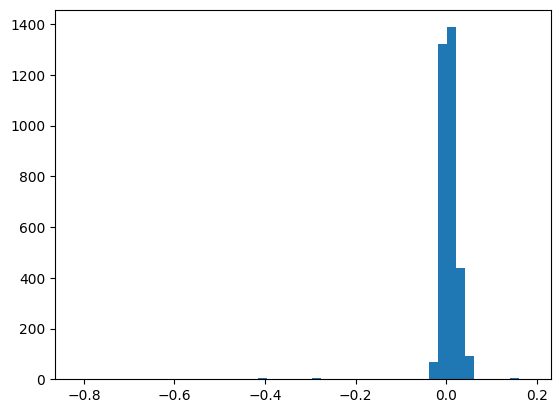

In [515]:
plt.hist(res, bins=50)
plt.show()

In [516]:
RSEd = ((y_test-pred)**2).sum()
RSE = np.sqrt(RSEd/(dfnorm.shape[0]-1-1))
RSE

0.02633972199560453

In [517]:
x=dfnorm[['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'AVG_SALE_PRICE_CATEGORY']]
y=dfnorm['lnprice']
model=sm.OLS(y,x).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                lnprice   R-squared (uncentered):                   0.876
Model:                            OLS   Adj. R-squared (uncentered):              0.876
Method:                 Least Squares   F-statistic:                          1.989e+04
Date:                Sun, 19 Mar 2023   Prob (F-statistic):                        0.00
Time:                        23:22:12   Log-Likelihood:                          976.20
No. Observations:               16878   AIC:                                     -1940.
Df Residuals:                   16872   BIC:                                     -1894.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [518]:
from sklearn.ensemble import RandomForestRegressor

select_features=['TOTAL_UNITS','LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'AVG_SALE_PRICE_CATEGORY']

# Select predictors
X = dfnorm[select_features]

# Encode categorical variables using one-hot encoding
#X = pd.get_dummies(X)

# Target variable
dfnorm.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
y = dfnorm['SALE_PRICE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: {:.2f}".format(rmse))

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: {:.2f}".format(np.mean(cv_scores)))

print("Feature importances:")
for feat, importance in zip(select_features, model.feature_importances_):
    print(" {:>20}: {:6.4f}".format(feat, importance))

# The value of R^2
print("R squared for the training data is {:4.3f}".format(model.score(X_train, y_train)))
print("Score against test data: {:4.3f}".format(model.score(X_test, y_test)))




Root Mean Squared Error: 0.05
Cross-validation scores:  [0.95181048 0.78051079 0.96899488 0.98593416 0.95324409]
Mean cross-validation score: 0.93
Feature importances:
          TOTAL_UNITS: 0.0085
     LAND_SQUARE_FEET: 0.0341
    GROSS_SQUARE_FEET: 0.9544
 AVG_SALE_PRICE_CATEGORY: 0.0030
R squared for the training data is 0.989
Score against test data: 0.937


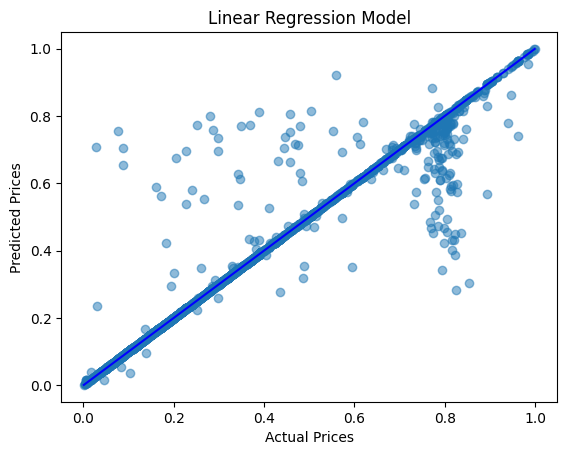

In [519]:
plt.scatter(y_test, y_pred, alpha=0.5)

# Add a regression line to the plot
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')

# Set axis labels and title
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Linear Regression Model')

# Show the plot
plt.show()

In [520]:
numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE', 'lnprice']
model = KMeans(n_clusters=6)
model.fit(dfnorm[numerical])

## J score
print('J-score = ', model.inertia_)
#print(' score = ', model.score(df_norm))
## include the labels into the data
print(model.labels_)


labels = model.labels_
md = pd.Series(labels)
dfnorm['clust'] = md
dfnorm.head(5)



J-score =  74.84846360814169
[2 0 2 ... 5 2 2]


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,...,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,lnprice,AVG_SALE_PRICE,AVG_SALE_PRICE_CATEGORY,pred,clust
0,ALPHABETCITY,07RENTALS-WALKUPAPARTMENTS,2B,374,1,C7,303EAST4THSTREET,10009,0.023952,0.016,...,1900.0,2,C7,0.754914,2013-02-05,0.904711,899788.974971,1,0.729443,2
1,ALPHABETCITY,07RENTALS-WALKUPAPARTMENTS,2,376,30,C4,274EASTSEVENTHSTREET,10009,0.038922,0.000,...,1910.0,2,C4,0.340862,2012-10-25,0.649338,899788.974971,1,0.727977,0
2,ALPHABETCITY,07RENTALS-WALKUPAPARTMENTS,2B,384,25,C4,241EAST2NDSTREET,10009,0.029940,0.000,...,1900.0,2,C4,0.767953,2013-04-18,0.910456,899788.974971,1,0.743239,2
3,ALPHABETCITY,07RENTALS-WALKUPAPARTMENTS,2B,398,52,C7,174EAST2NDSTREET,10009,0.026946,0.008,...,1900.0,2,C7,0.813922,2013-01-07,0.930020,899788.974971,1,0.787998,2
4,ALPHABETCITY,07RENTALS-WALKUPAPARTMENTS,2B,398,52,C7,174EAST2NDSTREET,10009,0.026946,0.008,...,1900.0,2,C7,0.813922,2012-10-26,0.930020,899788.974971,1,0.787998,2


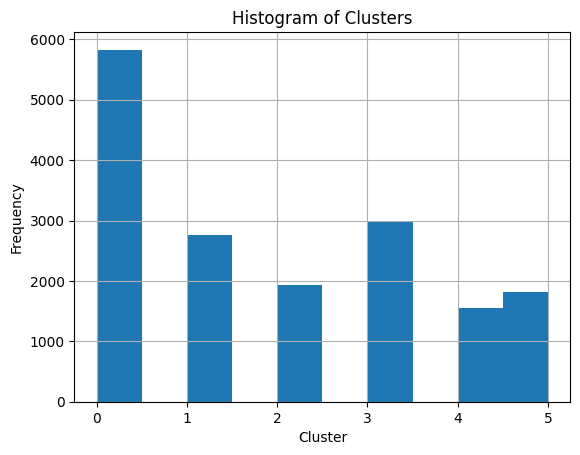

C:\Users\zacha\AppData\Local\Temp\ipykernel_9024\2308593350.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfnorm.groupby('clust').mean()


,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE,lnprice,AVG_SALE_PRICE,pred
clust,,,,,,,,,,,,,,
0,1106.763253,976.971007,10033.710928,0.002158,0.000877,0.002582,0.047612,0.122998,1957.799623,2.157660,0.388055,0.688450,9.514598e+05,0.384723
1,1179.322476,474.650742,10031.462541,0.001316,0.000437,0.001485,0.059549,0.171297,1947.925805,2.014477,0.145756,0.410387,8.940881e+05,0.162533
2,1112.432418,511.668566,10033.047126,0.012406,0.003115,0.013576,0.024455,0.035956,1935.554635,2.063698,0.810470,0.927353,1.025599e+06,0.774381
3,1122.539337,682.456645,10030.678607,0.002347,0.000383,0.002493,0.054268,0.149961,1953.379310,2.008035,0.248166,0.553408,9.312801e+05,0.260500
4,1384.628793,347.955455,10032.216914,0.001297,0.000367,0.001442,0.064113,0.189200,1941.879277,2.047127,0.061273,0.223878,8.545155e+05,0.081085
5,1093.067620,735.511820,10032.336449,0.003038,0.000695,0.003317,0.037252,0.083995,1951.894447,2.075316,0.572665,0.811529,9.789898e+05,0.559494


In [521]:


## histogram of the clusters
plt.hist(dfnorm['clust'])
plt.title('Histogram of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.grid()
plt.show()

dfnorm.groupby('clust').mean()

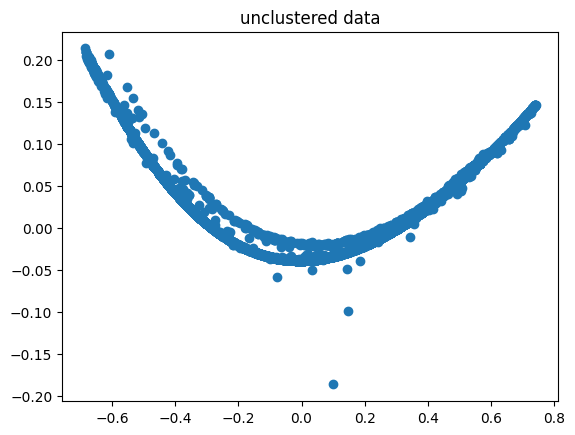

In [522]:
pca_data = PCA(n_components=2).fit(dfnorm[numerical])
pca_2d = pca_data.transform(dfnorm[numerical])
plt.scatter(pca_2d[:,0], pca_2d[:,1])
plt.title('unclustered data')
plt.show()

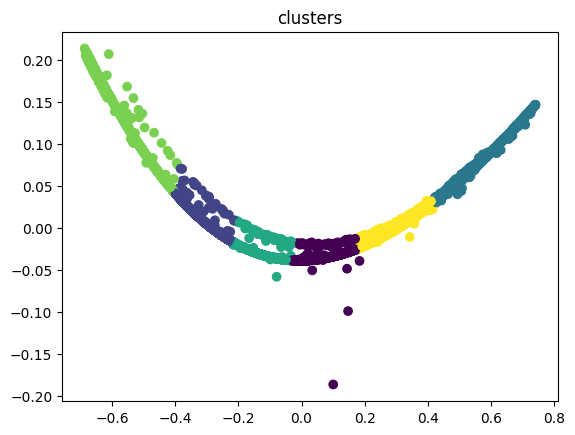

In [523]:
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=labels)
plt.title('clusters')
plt.show()


Plotting elbow method...
2 596.5601892742254
4 143.08861643186998
6 74.84846360814169
8 53.048046516234194
10 39.538366127487414
12 31.96578587292895
14 27.016634275081188
16 23.201241237129153
18 20.056951851921575


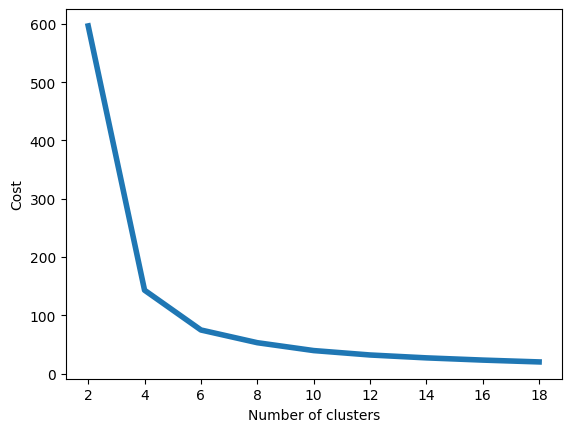

DONE


In [524]:


def elbow(data):
    print("\nPlotting elbow method...")
    sse = {}
    for k in range(2, 20, 2):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(data)
        print(k, kmeans.inertia_)
        sse[k] = kmeans.inertia_  
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=4)
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost")
    plt.show()
    print("DONE")
elbow(dfnorm[numerical])



In [525]:
def localRegressors(df, clusters, features, target):
    model_dict={}
    cluster_dict={}
    for cluster in range(clusters):
        clustData=df[df['clust'] == cluster].copy()
        if clustData.empty:
            continue
        x=clustData[features]
        y=clustData[target]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(x_train,y_train)
        model_dict[cluster]=model
        cluster_dict[cluster]={'x':x,'x_train':x_train, 'x_test':x_test, 'y':y, 'y_train':y_train, 'y_test':y_test}
    
    return model_dict, cluster_dict
features=["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET"]
models, clusters=localRegressors(dfnorm, 8, features, 'SALE_PRICE')
print(models)

{0: RandomForestRegressor(random_state=42), 1: RandomForestRegressor(random_state=42), 2: RandomForestRegressor(random_state=42), 3: RandomForestRegressor(random_state=42), 4: RandomForestRegressor(random_state=42), 5: RandomForestRegressor(random_state=42)}


In [526]:
def testClusters(df, models,clusters):
    for cluster, model in models.items():
        clustData=clusters[cluster]
        x = clustData['x']
        y = clustData['y']
        x_test=clustData['x_test']
        x_train=clustData['x_train']
        y_test=clustData['y_test']
        y_train=clustData['y_train']
        cv_scores = cross_val_score(model, x, y, cv=5)
        print("Cluster {} - Cross-validation scores: ".format(cluster), cv_scores)
        print("Cluster {} - Mean cross-validation score: {:.2f}".format(cluster, np.mean(cv_scores)))
        print("Cluster {} - Feature importances:".format(cluster))
        for feat, importance in zip(features, model.feature_importances_):
            print(" {:>20}: {:6.4f}".format(feat, importance))
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        print("Cluster {} - Root Mean Squared Error: {:.2f}".format(cluster, rmse))
        print("Cluster {} - R squared for the training data is {:4.3f}".format(cluster, model.score(x_train, y_train)))
        print("Cluster {} - Score against test data: {:4.3f}".format(cluster, model.score(x_test, y_test)))

        plt.scatter(y_test, y_pred, alpha=0.5)
        p1 = max(max(y_pred), max(y_test))
        p2 = min(min(y_pred), min(y_test))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('Actual Prices')
        plt.ylabel('Predicted Prices')
        plt.title('Linear Regression Model - Cluster {}'.format(cluster))
        plt.show()

Cluster 0 - Cross-validation scores:  [0.98093688 0.88240908 0.97304125 0.99993949 0.97282623]
Cluster 0 - Mean cross-validation score: 0.96
Cluster 0 - Feature importances:
     LAND_SQUARE_FEET: 0.1250
    GROSS_SQUARE_FEET: 0.8750
Cluster 0 - Root Mean Squared Error: 0.01
Cluster 0 - R squared for the training data is 0.995
Cluster 0 - Score against test data: 0.952


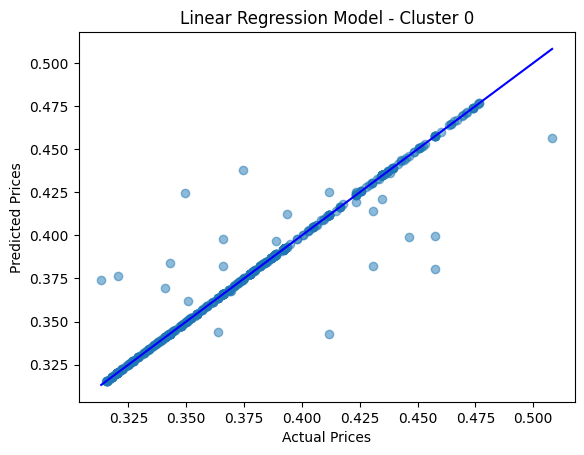

Cluster 1 - Cross-validation scores:  [0.9960903  0.94431732 0.98398284 0.99006705 0.98080851]
Cluster 1 - Mean cross-validation score: 0.98
Cluster 1 - Feature importances:
     LAND_SQUARE_FEET: 0.6802
    GROSS_SQUARE_FEET: 0.3198
Cluster 1 - Root Mean Squared Error: 0.00
Cluster 1 - R squared for the training data is 0.997
Cluster 1 - Score against test data: 0.973


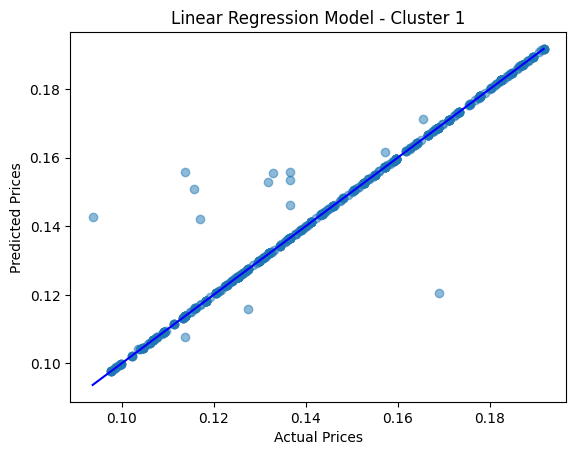

Cluster 2 - Cross-validation scores:  [0.91896921 0.79421464 0.944139   0.95668728 0.92838835]
Cluster 2 - Mean cross-validation score: 0.91
Cluster 2 - Feature importances:
     LAND_SQUARE_FEET: 0.1856
    GROSS_SQUARE_FEET: 0.8144
Cluster 2 - Root Mean Squared Error: 0.02
Cluster 2 - R squared for the training data is 0.986
Cluster 2 - Score against test data: 0.946


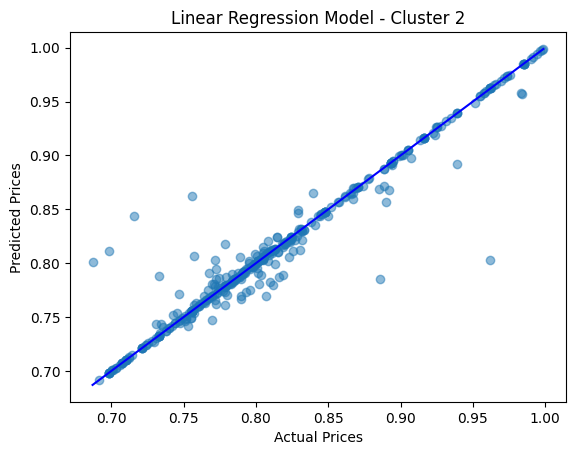

Cluster 3 - Cross-validation scores:  [0.99740688 0.88921377 0.98484938 0.97016411 0.97005808]
Cluster 3 - Mean cross-validation score: 0.96
Cluster 3 - Feature importances:
     LAND_SQUARE_FEET: 0.2502
    GROSS_SQUARE_FEET: 0.7498
Cluster 3 - Root Mean Squared Error: 0.01
Cluster 3 - R squared for the training data is 0.995
Cluster 3 - Score against test data: 0.965


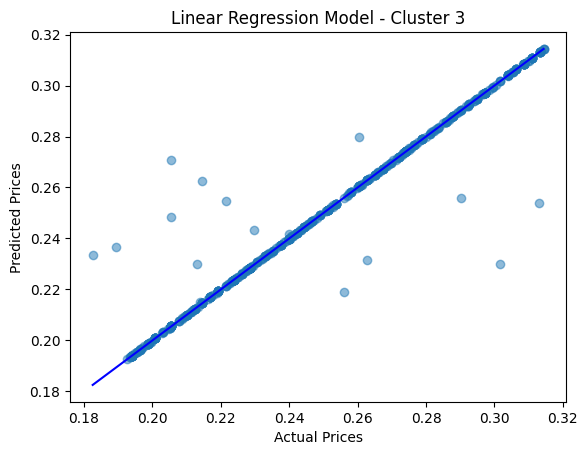

Cluster 4 - Cross-validation scores:  [0.9349722  0.99549805 0.93916554 0.99639106 0.95993904]
Cluster 4 - Mean cross-validation score: 0.97
Cluster 4 - Feature importances:
     LAND_SQUARE_FEET: 0.5350
    GROSS_SQUARE_FEET: 0.4650
Cluster 4 - Root Mean Squared Error: 0.00
Cluster 4 - R squared for the training data is 0.987
Cluster 4 - Score against test data: 0.990


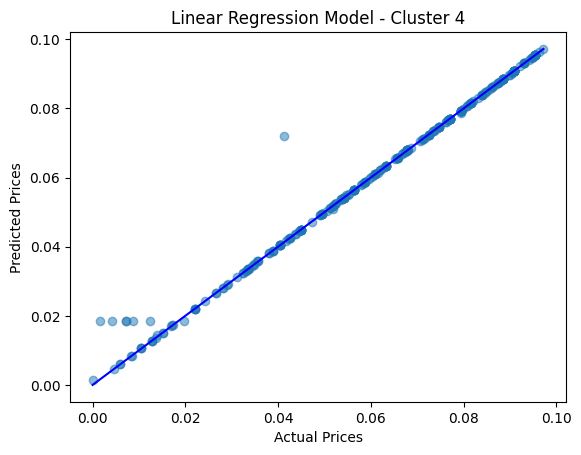

Cluster 5 - Cross-validation scores:  [0.92078746 0.47035972 0.98781743 0.98288191 0.9601957 ]
Cluster 5 - Mean cross-validation score: 0.86
Cluster 5 - Feature importances:
     LAND_SQUARE_FEET: 0.1118
    GROSS_SQUARE_FEET: 0.8882
Cluster 5 - Root Mean Squared Error: 0.02
Cluster 5 - R squared for the training data is 0.986
Cluster 5 - Score against test data: 0.936


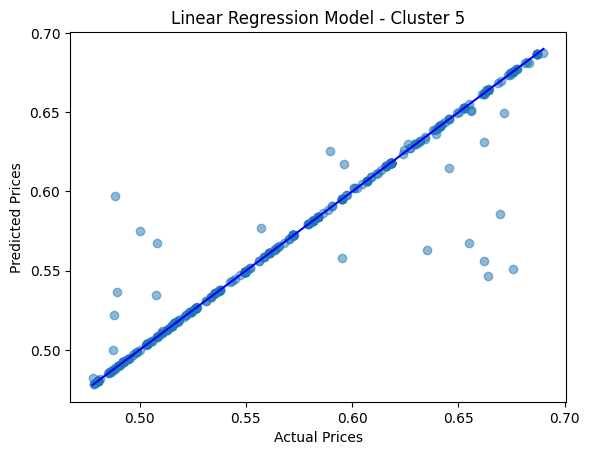

In [527]:
testClusters(dfnorm, models, clusters)